In [1]:
import scanpy as sc
import pandas as pd 
import numpy as np
import anndata
import re
import h5py
import random
import scipy.sparse as scs
import matplotlib.pyplot as plt
from scipy.sparse import csc_matrix
from concurrent.futures import ThreadPoolExecutor, as_completed
random.seed(123)
import warnings
from concurrent.futures import ProcessPoolExecutor
import copy
import os
from tqdm import tqdm
import math
import re
import multiprocessing
warnings.filterwarnings("ignore")
import gc

In [2]:
def run_leiden(adata, resolution, key_added):
    
    adata_copy = copy.deepcopy(adata)
    adata_clustering = sc.tl.leiden(adata_copy, resolution=resolution, key_added=key_added,n_iterations=3, copy=True)
    return adata_clustering.obs

def run_leiden_parallel(adata, tasks):
    with ProcessPoolExecutor(max_workers=5) as executor:
        futures = [executor.submit(run_leiden, copy.deepcopy(adata), resolution, key_added) for resolution, key_added in tasks]
        
        results = [future.result() for future in futures]

    for result, (_, key_added) in zip(results, tasks):
        adata.obs[key_added] = result[key_added]

    return adata

# Read h5ad from round 2

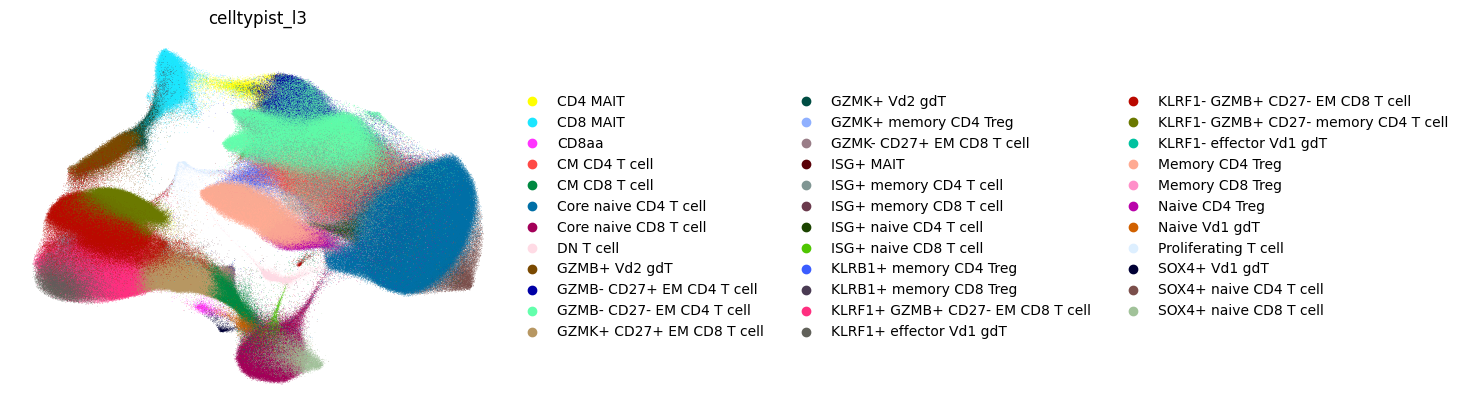

In [3]:
adata_T=sc.read_h5ad('Tcells_leiden.h5ad')
adata_T.obs.index=adata_T.obs['barcodes']
adata_T.obs['celltypist_l3'] = adata_T.obs['celltypist_l3'].astype(str)
sc.pl.umap(adata_T, color=['celltypist_l3'], size=0.5,ncols=1 ,frameon=False)

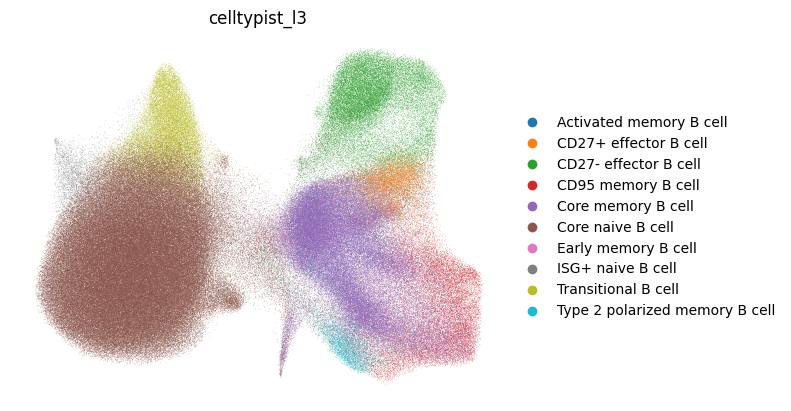

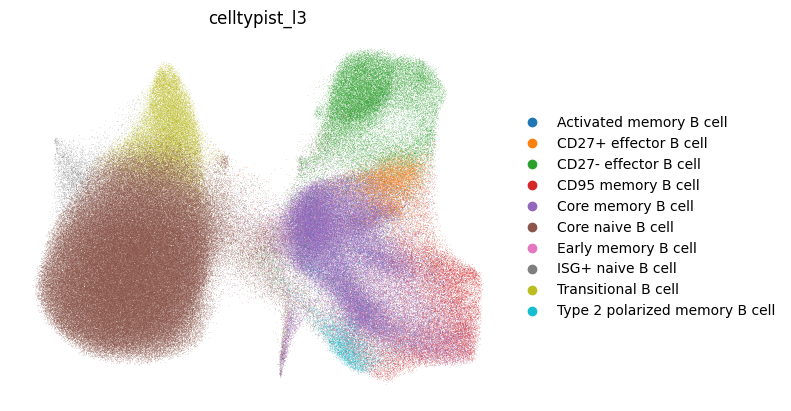

In [4]:
adata_B=sc.read_h5ad('Bcells_leiden.h5ad')
adata_B.obs.index=adata_B.obs['barcodes']
adata_B.obs['celltypist_l3'] = adata_B.obs['celltypist_l3'].astype(str)
sc.pl.umap(adata_B, color=['celltypist_l3'], size=0.5,ncols=1 ,frameon=False)
adata_B=adata_B[adata_B.obs['leiden_resolution_1']!='14']
sc.pl.umap(adata_B, color=['celltypist_l3'], size=0.5,ncols=1 ,frameon=False)

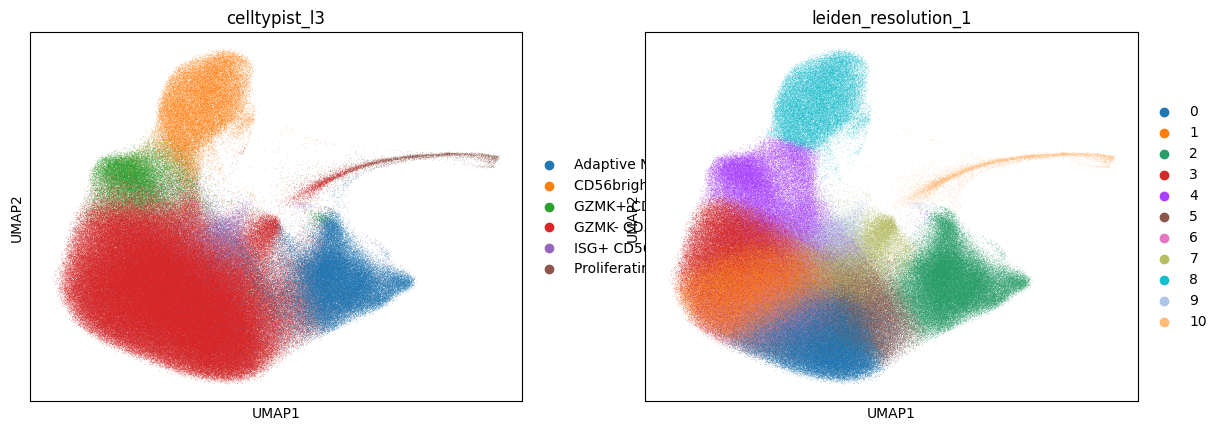

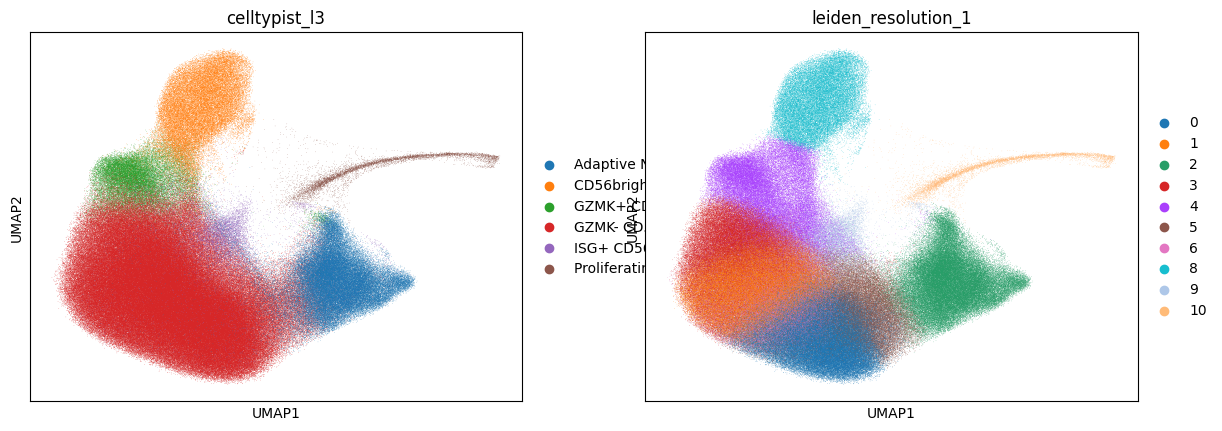

In [5]:
adata_NK=sc.read_h5ad('NKcells_leiden.h5ad')
adata_NK.obs.index=adata_NK.obs['barcodes']
adata_NK.obs['celltypist_l3'] = adata_NK.obs['celltypist_l3'].astype(str)
sc.pl.umap(adata_NK, color=['celltypist_l3','leiden_resolution_1'], size=0.5,ncols=2 )
adata_NK=adata_NK[adata_NK.obs['leiden_resolution_1']!='7']
adata_NK.obs.loc[adata_NK.obs['leiden_resolution_1'] =='10' , 'celltypist_l3'] = 'Proliferating NK cell'
sc.pl.umap(adata_NK, color=['celltypist_l3','leiden_resolution_1'], size=0.5,ncols=2 )

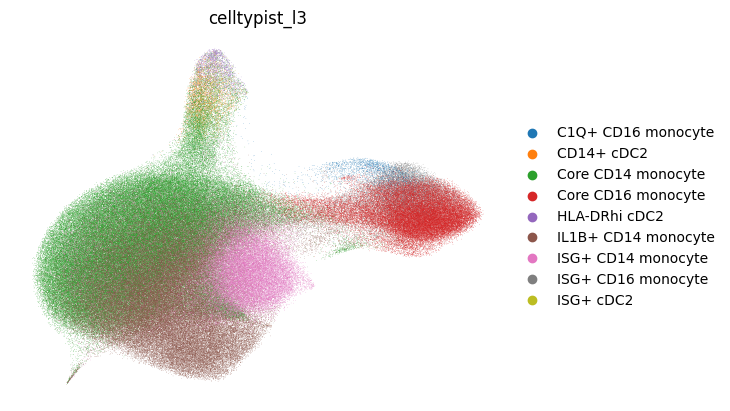

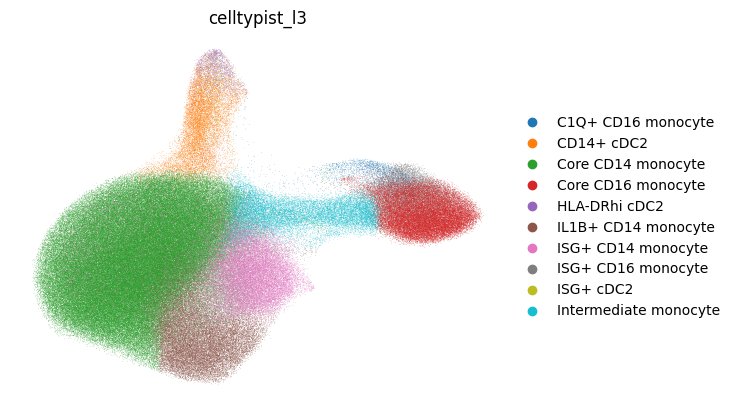

In [6]:
adata_Myeloid=sc.read_h5ad('Myeloidcells_leiden.h5ad')
adata_Myeloid.obs.index=adata_Myeloid.obs['barcodes']
adata_Myeloid.obs['celltypist_l3'] = adata_Myeloid.obs['celltypist_l3'].astype(str)
sc.pl.umap(adata_Myeloid, color=['celltypist_l3'], size=0.5,ncols=1 ,frameon=False)
adata_Myeloid.obs.loc[(adata_Myeloid.obs['leiden_resolution_1'] =='9') & (adata_Myeloid.obs['celltypist_l3'] == 'Core CD14 monocyte'), 'celltypist_l3'] = 'CD14+ cDC2'
adata_Myeloid.obs['celltypist_l3']= adata_Myeloid.obs['celltypist_l3'].astype(str)
adata_Myeloid.obs.loc[adata_Myeloid.obs['leiden_resolution_1.5'] =='10' , 'celltypist_l3'] = 'Intermediate monocyte'
adata_Myeloid=adata_Myeloid[adata_Myeloid.obs['leiden_resolution_2']!='13']
adata_Myeloid=adata_Myeloid[adata_Myeloid.obs['leiden_resolution_2']!='24']
adata_Myeloid=adata_Myeloid[adata_Myeloid.obs['leiden_resolution_2']!='18']
adata_Myeloid.obs.loc[(~adata_Myeloid.obs['leiden_resolution_2'].isin(['3','15'])) & (adata_Myeloid.obs['celltypist_l3'] == 'IL1B+ CD14 monocyte'), 'celltypist_l3'] =  'Core CD14 monocyte'
sc.pl.umap(adata_Myeloid, color=['celltypist_l3'], size=0.5,ncols=1 ,frameon=False)

### re-define cDC2

In [7]:
adata_sub=adata_Myeloid[adata_Myeloid.obs['celltypist_l3'].isin(['HLA-DRhi cDC2','ISG+ cDC2','CD14+ cDC2'])]
adata_sub.raw=adata_sub
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)
sc.pp.highly_variable_genes(adata_sub)
adata_sub = adata_sub[:, adata_sub.var_names[adata_sub.var['highly_variable']]]
sc.pp.scale(adata_sub)
sc.tl.pca(adata_sub, svd_solver='arpack')

In [8]:
%%time
import scanpy.external as sce

sce.pp.harmony_integrate(adata_sub, 'pool_id',max_iter_harmony = 10)

2024-05-07 04:22:31,522 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-05-07 04:22:39,884 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-05-07 04:22:39,968 - harmonypy - INFO - Iteration 1 of 10
2024-05-07 04:22:45,941 - harmonypy - INFO - Iteration 2 of 10
2024-05-07 04:22:52,081 - harmonypy - INFO - Iteration 3 of 10
2024-05-07 04:22:57,117 - harmonypy - INFO - Iteration 4 of 10
2024-05-07 04:23:00,853 - harmonypy - INFO - Iteration 5 of 10
2024-05-07 04:23:04,485 - harmonypy - INFO - Iteration 6 of 10
2024-05-07 04:23:07,317 - harmonypy - INFO - Iteration 7 of 10
2024-05-07 04:23:09,807 - harmonypy - INFO - Iteration 8 of 10
2024-05-07 04:23:12,236 - harmonypy - INFO - Iteration 9 of 10
2024-05-07 04:23:14,811 - harmonypy - INFO - Iteration 10 of 10
2024-05-07 04:23:17,362 - harmonypy - INFO - Stopped before convergence


CPU times: user 21min 3s, sys: 26min 2s, total: 47min 6s
Wall time: 46.4 s


In [9]:
%%time
sc.pp.neighbors(adata_sub, n_neighbors=50,use_rep='X_pca_harmony', n_pcs=30)
sc.tl.umap(adata_sub,min_dist=0.45)

  0%|          | 0/200 [00:00<?, ?it/s]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
CPU times: user 1min 27s, sys: 7.48 s, total: 1min 34s
Wall time: 44.2 s


In [10]:
%%time
tasks = [(1, "leiden_resolution_1"),(1.5, "leiden_resolution_1.5"),(2, "leiden_resolution_2")]
adata_sub = run_leiden_parallel(adata_sub, tasks)

CPU times: user 1.21 s, sys: 11.6 s, total: 12.8 s
Wall time: 32.2 s


In [11]:
adata_sub=adata_sub.raw.to_adata()
adata_sub.raw=adata_sub
sc.pp.normalize_total(adata_sub, target_sum=1e4)
sc.pp.log1p(adata_sub)

In [12]:
sc.tl.rank_genes_groups(adata_sub, 'leiden_resolution_1', use_raw=False,method='t-test')

In [13]:
adata=adata_sub

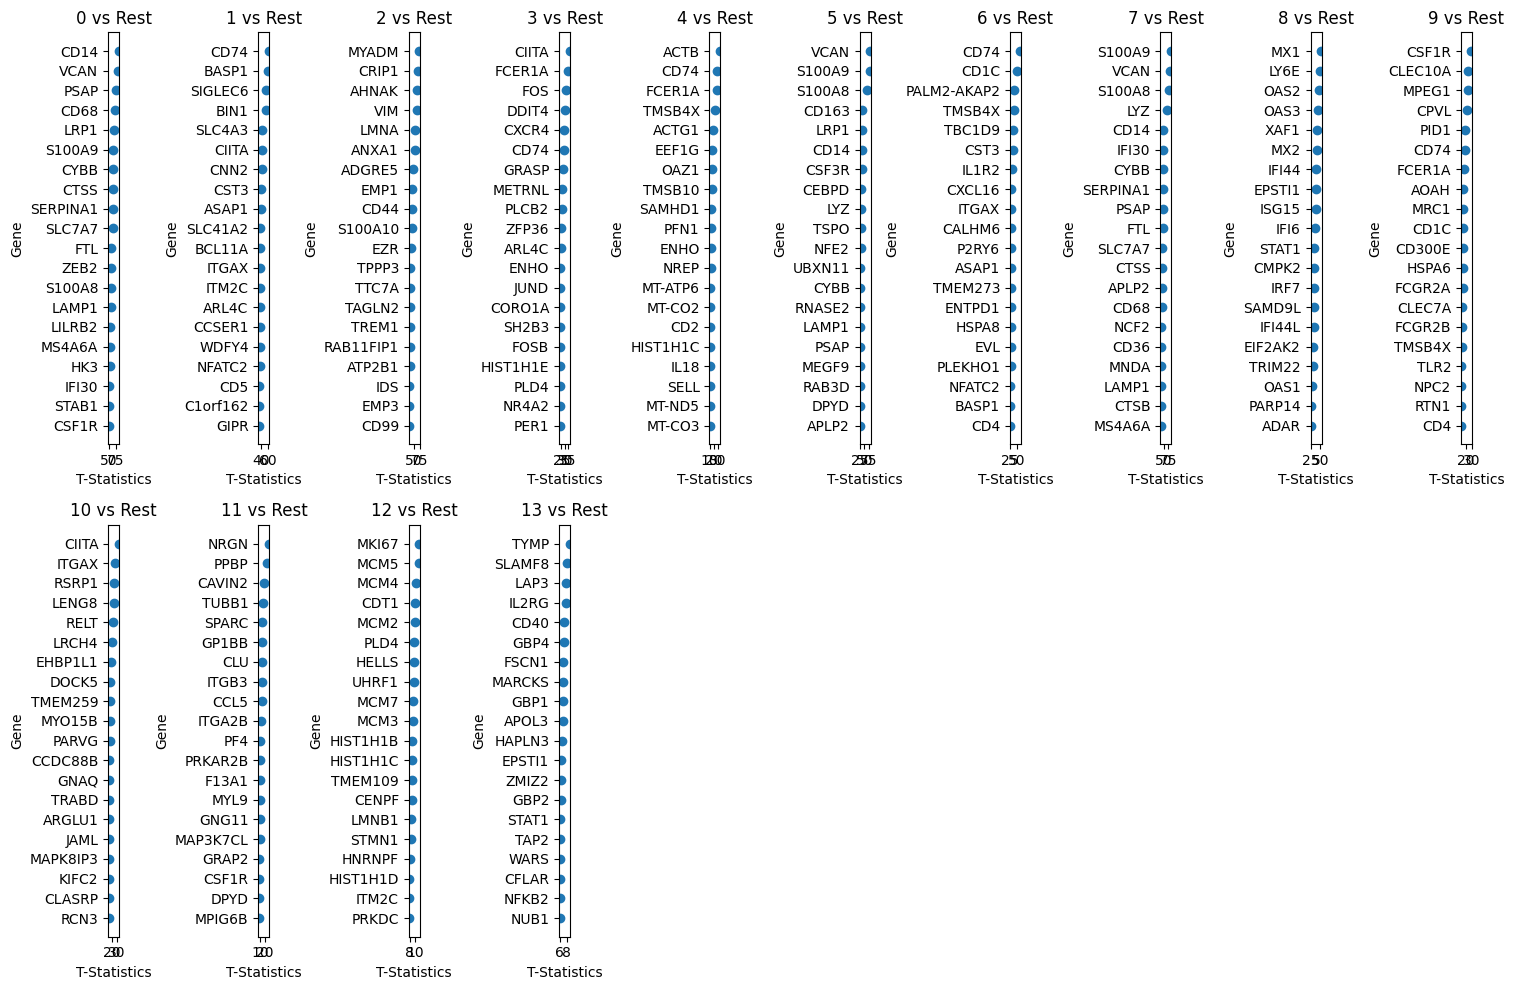

In [14]:
df = sc.get.rank_genes_groups_df(adata, group=None)
df = df.groupby('group').head(20).reset_index(drop=True)
groups = df.groupby('group')

n_groups = len(groups)
n_cols = 10
n_rows = math.ceil(n_groups / n_cols)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))

if n_rows == 1:
    axs = axs.reshape(1, -1)

for ax in axs.flat:
    ax.set_visible(False)

for i, (name, group) in enumerate(groups):
    row, col = divmod(i, n_cols)
    ax = axs[row, col]
    ax.set_visible(True)
    ax.scatter(group['scores'], group['names'])
    ax.invert_yaxis()
    ax.set_title(str(name) + " vs Rest")
    ax.set_xlabel('T-Statistics')
    ax.set_ylabel('Gene')

plt.tight_layout()

In [15]:
adata_sub.obs['celltypist_l3']= adata_sub.obs['celltypist_l3'].astype(str)
adata_sub.obs.loc[(adata_sub.obs['leiden_resolution_1'].isin(['0','2','7','5','9'])) , 'celltypist_l3'] =  'CD14+ cDC2'
adata_sub.obs.loc[(adata_sub.obs['leiden_resolution_1'].isin(['8'])) , 'celltypist_l3'] =  'ISG+ cDC2'
adata_sub.obs.loc[(adata_sub.obs['leiden_resolution_1'].isin(['1','3','4','6','10','12'])) , 'celltypist_l3'] =  'HLA-DRhi cDC2'
adata_sub=adata_sub[adata_sub.obs['leiden_resolution_1']!='11']


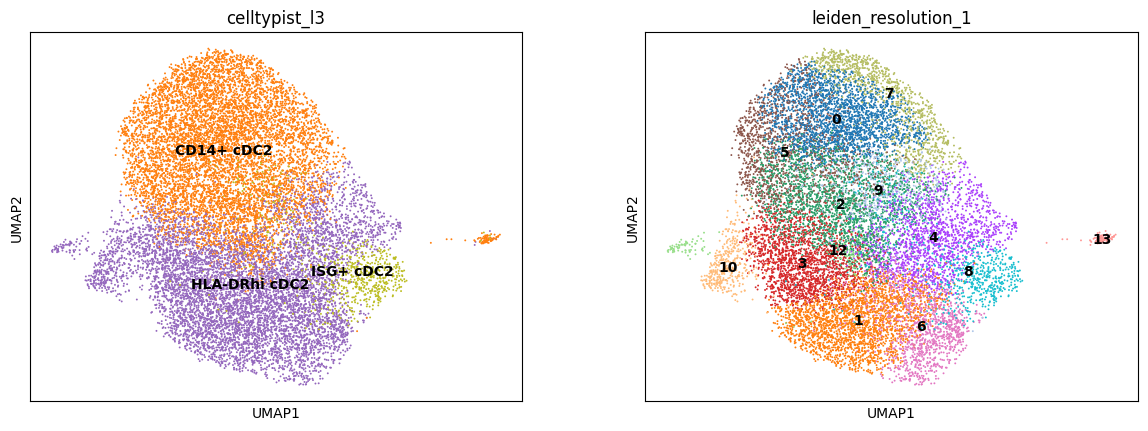

In [16]:

sc.pl.umap(adata_sub, color=['celltypist_l3','leiden_resolution_1'], legend_loc='on data',use_raw=False, ncols=4)


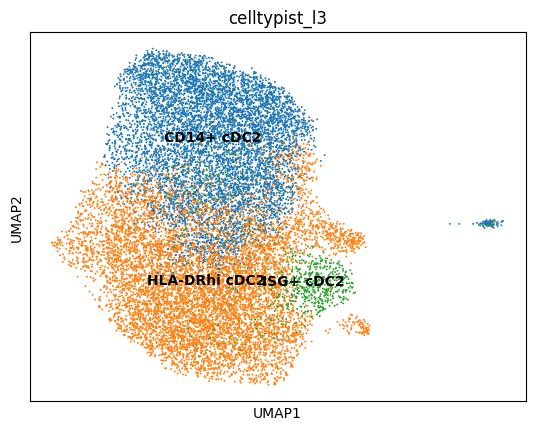

In [45]:
#sc.pl.umap(adata_sub, color=['celltypist_l3'], legend_loc='on data',use_raw=False, ncols=4)

In [17]:
adata_sub=adata_sub.raw.to_adata()

In [18]:
adata_sub_other_mono=adata_Myeloid[~adata_Myeloid.obs['celltypist_l3'].isin(['HLA-DRhi cDC2','ISG+ cDC2','CD14+ cDC2'])]

In [19]:
adata_Myeloid=anndata.concat([adata_sub,adata_sub_other_mono])

In [21]:
adata_Myeloid.obs['celltypist_l3'].value_counts()

celltypist_l3
Core CD14 monocyte       205466
ISG+ CD14 monocyte        33135
IL1B+ CD14 monocyte       33078
Core CD16 monocyte        29374
Intermediate monocyte     20030
ISG+ CD16 monocyte        12638
CD14+ cDC2                 7613
HLA-DRhi cDC2              7464
C1Q+ CD16 monocyte         2375
ISG+ cDC2                   689
Name: count, dtype: int64

In [20]:
adata_round_2_combined=anndata.concat([adata_NK,adata_B,adata_T,adata_Myeloid])

KeyboardInterrupt: 

In [ ]:
adata_round_2_combined

In [ ]:
del adata_NK
del adata_T
del adata_Myeloid
del adata_B


In [ ]:
gc.collect()

# Read the rest of adata

In [ ]:
celltype_from_round_2=np.unique(adata_round_2_combined.obs['celltypist_l3'])

In [ ]:
files = os.listdir("h5_cleaned_by_celltype/")

In [ ]:
celltype_from_round_2=[x+".h5ad" for x in celltype_from_round_2]

In [ ]:
remaining_celltypes = list(set(files) - set(celltype_from_round_2))

In [ ]:
adata_list=[]
for i in remaining_celltypes:
    adata_sinlge=sc.read_h5ad("h5_cleaned_by_celltype/"+i)
    adata_list.append(adata_sinlge)

In [ ]:
adata_remaining=anndata.concat(adata_list)

In [ ]:
adata_combined=anndata.concat([adata_round_2_combined,adata_remaining])

In [ ]:
adata_combined.obs.index=adata_combined.obs['barcodes']

In [ ]:
del adata_combined.obsm
del adata_combined.obs["leiden_2"]
del adata_combined.obs["leiden"]
del adata_combined.raw

In [ ]:
def are_all_nonzero_integers(csr):
    non_zero_elements = csr.data
    return np.all(np.equal(np.mod(non_zero_elements, 1), 0))
result = are_all_nonzero_integers(adata_combined.X)
print("All non-zero elements are integers:", result)

In [ ]:
unique_sample_ids = np.unique(adata_combined.obs['sampleID']).tolist()

In [53]:
for pbmc_sample_id in tqdm(unique_sample_ids, desc='Processing samples'):
    adata_single = adata_combined[adata_combined.obs['sampleID'] == pbmc_sample_id]
    missing_columns = adata_single.obs.columns[adata_single.obs.isna().all()]
    if missing_columns.any():
        print(f"Missing meta data in {adata_single.obs['sampleID'][0]}, columns removed: {', '.join(missing_columns)}")
        adata_single.obs.drop(columns=missing_columns, inplace=True)
    adata_single.write_h5ad("h5_by_sample/" + pbmc_sample_id + ".h5ad")

Processing samples:  23% 54/235 [06:46<22:14,  7.37s/it]

Missing meta data in PB03364-001, columns removed: cmv_status, cmv_index


Processing samples:  26% 62/235 [07:46<23:36,  8.19s/it]

Missing meta data in PB03385-003, columns removed: age_enrollment, biological_sex, race


Processing samples: 100% 235/235 [28:30<00:00,  7.28s/it]


In [ ]:
adata_combined.write_h5ad("SF4-2024-05-06.h5ad")